In [66]:
from pathlib import Path 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from collections import OrderedDict
import sys
import os
import seaborn as sns
import researchpy as rp
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.nonparametric.smoothers_lowess import lowess

#sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import rr, prep, var_dict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
ylim_dict = {'snap' : [0,3], 'ssrs': [0,2], 'masc' : [0,3], 'pc': [0,4]}

In [68]:
trtnames = ['M', 'P', 'C']
timepoints = [0,90,270, 420]
delta = 50
timepoints_range = [[time - delta, time + delta] for time in timepoints]
timepoints_range
y_lim = [0,3]
x_lim = [-10, 450]

In [69]:
save_path = Path('/Users/alina/Desktop/MIT/code/data/output/figures/mediator_regression_14months')

In [70]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived = '/Users/alina/Desktop/MIT/code/data/output/derived_data'

In [71]:
snap = pd.read_csv(Path(data_derived, 'snap_14_and_mediators.csv'))
ssrs = pd.read_csv(Path(data_derived, 'ssrs_14_and_mediators.csv'))
masc = pd.read_csv(Path(data_derived, 'masc_14_and_mediators.csv'))
pc = pd.read_csv(Path(data_derived, 'pc_14_and_mediators.csv'))
qsts =['snap', 'ssrs', 'masc', 'pc']
data_dict = dict(zip(['snap', 'ssrs', 'masc', 'pc'], [snap, ssrs, masc, pc]))

In [72]:
#remove subjects from the 'assessemnt' period (before baseline)
for key, df in data_dict.items():
    data_dict[key] = df[(df['trtname'] != 'A') & (df['days_baseline']>=0)].copy() 



In [73]:
interaction_predictors = ['days_baseline', 'site', 'trtname'] #time, site, treatment group

# mediator variables
comorb_mediators  = ['cdorodd' , 'pso', 'psoi', 'pag', 'pagi', 'pga', 'pgai' ,'psa'] #ODD/CD or anx excluding specific phobia 
services_mediators =  ['demo61'] #reciept of public assistance 
prev_med_mediators = ['hi_24'] #medication intake prior to study 

#moderator variables #
#accept_moderator = ['d2dresp'] # initail acceptance of treatment 
accept_moderator = ['d2dresp'] # initail acceptance of treatment # binary
raters = ['Teacher', 'Parent']

med_mod_list = np.concatenate([[comorb_mediators[0]], ['anx'], services_mediators, prev_med_mediators, accept_moderator, ['sex']])
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

In [74]:
#outcome variablles 
snap_vars = ['snainatx', 'snahypax', 'snaoddx'] #inattention_mean, hyperactie mean
ssrs_vars = ['sspintx', 'ssptossx']# social skills mean, internalizing mean 
masc_vars = ['masc_masctotalt']
pc_vars = ['pcrcpax', 'pcrcprx'] # power assertion, personal closeness
#wechsler_vars = ['w1readb','w2math','w3spell' ]
outcomes = np.concatenate([snap_vars, ssrs_vars, masc_vars, pc_vars])

outcomes_dict  = {'snap' : snap_vars, 'ssrs' : ssrs_vars, 'masc': masc_vars, 'pc': pc_vars}#, 'wechsler': wechsler_vars}

In [75]:
#outcome variables 
outcomes_written = ['SNAP Inattention', 'SNAP Hyperactivity', 'SNAP Aggressive','SSRS Internalizing', 'SSRS Social Skills', 'MASC total Score', 'Parent-Child Power Assertion', 'Parent-Child Personal Closeness' ]
outcomes_dict_fig = dict(zip(outcomes, outcomes_written))
outcomes_dict_fig

# treatment names 
trt_dict = {'M': 'Medication Management', 'P': 'Behavioral Treatment', 'C': 'Combined Treatment'}

#mediators 
med_written = ['CD or ODD', 'Anxiety', 'Public Assistance', 'Prior Medication', 'Initial Acceptance of Treatment Arm', 'Sex']
med_options = [['No', ''],['No', ''] ,['No', ''],['No', ''], ['Low', 'High'], ['Male', 'Female']]

# mediator variable names spelled out 
med_dict_fig = {} #for figure titles 
options_dict = {}
for i, med in enumerate(med_mod_list):
    med_dict_fig[med] = [med_options[i][j] + ' ' + med_written[i] for j in range(2)]
med_dict_fig

# outcome values for mediators and moderators 
values_possible = [[0,1],[0,1],[1,2],[1,2],[1,2,3,4,5,6] ,['M', 'F']]
values_possible

med_values = dict(zip(med_mod_list, values_possible))
med_values

{'cdorodd': [0, 1],
 'anx': [0, 1],
 'demo61': [1, 2],
 'hi_24': [1, 2],
 'd2dresp': [1, 2, 3, 4, 5, 6],
 'sex': ['M', 'F']}

In [76]:
gen_interact_formula = ' days_baseline + C(site) + C(trtname)' #

In [77]:
#include mediators and moderator as main effect and in interaction 
gen_med_formulas = [ gen_interact_formula +' * '+  str(med) for med in med_mod_list]
gen_med_formulas

formulas =  [[[' ~ '.join((var, gen_med_form)) for var in values] for gen_med_form in gen_med_formulas] for values in outcomes_dict.values()] 
formulas_dict = dict(zip(outcomes_dict.keys(), formulas))
formulas_dict

{'snap': [['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
   'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
   'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
  ['snainatx ~  days_baseline + C(site

In [78]:
groups = 'src_subject_id'
alpha = 0.05
raters = ['Teacher', 'Parent']

In [79]:
for qst in data_dict.keys():
    print((qst))
    print((data_dict[qst]['days_baseline'].value_counts() < 0).sum())
    print('L', (data_dict[qst][ (data_dict[qst]['trtname'] == 'L') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('M', (data_dict[qst][ (data_dict[qst]['trtname'] == 'M') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('P', (data_dict[qst][ (data_dict[qst]['trtname'] == 'P') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('C', (data_dict[qst][ (data_dict[qst]['trtname'] == 'C') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('A', (data_dict[qst][ (data_dict[qst]['trtname'] == 'A') &(data_dict[qst]['days_baseline'] >=0)].shape))
    

snap
0
L (0, 17)
M (977, 17)
P (1118, 17)
C (1135, 17)
A (0, 17)
ssrs
0
L (0, 16)
M (988, 16)
P (1114, 16)
C (1135, 16)
A (0, 16)
masc
0
L (0, 14)
M (333, 14)
P (382, 14)
C (372, 14)
A (0, 14)
pc
0
L (0, 15)
M (1211, 15)
P (1359, 15)
C (1382, 15)
A (0, 15)


## RR analzsis

In [80]:
#for snap and ssrs, teacher and parent rater separated 

cols = np.concatenate([['src_subject_id'], interaction_predictors])
print(cols)
results_s = {}
for i, qst in enumerate(['snap', 'ssrs']) :

    results_rater = {}
    for rater in raters: 
        results_ = {}
        
        for j, med in enumerate(med_mod_list):
            
            for k, var in enumerate(outcomes_dict[qst]):
                cols_total = np.concatenate([cols, [med, var]])
                print(cols_total)
                formula = formulas[i][j][k]
                data = data_dict[qst][(data_dict[qst]['version_form'] == rater) & (data_dict[qst][cols_total].notna().all(axis=1))]
                print(data.shape)
                groups = data['src_subject_id']
                result = smf.mixedlm(formula, data, groups = groups).fit()
                results_[str(med) + '_' + str(var) ] = result
                
        results_rater[rater] = results_
        
    results_s[qst] = results_rater

['src_subject_id' 'days_baseline' 'site' 'trtname']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snainatx']
(1122, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snahypax']
(1122, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snaoddx']
(1122, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snainatx']
(1141, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snahypax']
(1141, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snaoddx']
(1141, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snainatx']
(1071, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snahypax']
(1071, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snaoddx']
(1071, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snainatx']
(151, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snahypax']
(151, 17)
['src_subject_id' 'days_baseline' 'site' 'trtnam

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snainatx']
(953, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snahypax']
(953, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snaoddx']
(953, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snainatx']
(1159, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snahypax']
(1159, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snaoddx']
(1159, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snainatx']
(1983, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snahypax']
(1983, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snaoddx']
(1983, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snainatx']
(2038, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snahypax']
(2038, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snaoddx']
(2038, 17)
['src_subject_id' 'days

In [81]:
# for masc and pc, no rater 

cols = np.concatenate([['src_subject_id'], interaction_predictors])
print(cols)
results_m = {}
for i, qst in enumerate(['masc', 'pc']) :
    results_ = {}
    for j, med in enumerate(med_mod_list):

        for k, var in enumerate(outcomes_dict[qst]):
            cols_total = np.concatenate([cols, [med, var]])
            print(cols_total)
            formula = formulas[i+2][j][k]
            data = data_dict[qst][cols_total].dropna()
            groups = data['src_subject_id']
            result = smf.mixedlm(formula, data, groups = groups).fit()
            results_[str(med) + '_' + str(var) ] = result
    results_m[qst] = results_
            

['src_subject_id' 'days_baseline' 'site' 'trtname']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'h

In [82]:
results = {'snap': results_s['snap'], 'ssrs' : results_s['ssrs'], 'masc': results_m['masc'], 'pc': results_m['pc'] }

In [83]:
def split_on_occurrence(s, char, occurrence=1):
    if occurrence == 1:
        # Find the index of the first occurrence of the character
        index = s.find(char)
    elif occurrence == 2:
        # Find the index of the second occurrence of the character
        first_occurrence = s.find(char)
        index = s.find(char, first_occurrence + 1)
    else:
        raise ValueError("Occurrence must be 1 or 2")

    # If the occurrence is found, split the string
    if index != -1:
        return s[:index], s[index+1:]
    else:
        # If the occurrence isn't found, return the original string
        return s, ''

In [85]:
data_dict['snap']

,Unnamed: 0,src_subject_id,interview_date,interview_age,sex,snainatx,snahypax,snaoddx,days_baseline,site,version_form,trtname,cdorodd,anx,hi_24,demo61,d2dresp
1,1,P1002,1997-06-03,120,M,1.00,0.50,1.25,0,1,Parent,C,NaN,0.0,2.0,NaN,NaN
2,2,P1002,1997-06-03,120,M,1.11,1.00,0.88,0,1,Parent,C,NaN,0.0,2.0,NaN,NaN
3,3,P1002,1997-09-19,124,M,0.33,0.33,0.63,108,1,Parent,C,NaN,0.0,2.0,NaN,NaN
4,4,P1002,1998-01-03,127,M,0.44,0.17,0.13,214,1,Parent,C,NaN,0.0,2.0,NaN,NaN
5,5,P1002,1998-01-13,127,M,0.67,0.50,0.75,224,1,Parent,C,NaN,0.0,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5228,5228,P1839,1995-05-23,75,M,0.44,0.83,1.13,99,4,Teacher,C,0.0,1.0,NaN,2.0,5.0
5229,5229,P1839,1995-10-25,80,M,0.33,0.17,0.63,254,4,Teacher,C,0.0,1.0,NaN,2.0,5.0
5230,5230,P1839,1996-06-02,88,M,0.33,0.50,0.50,475,4,Teacher,C,0.0,1.0,NaN,2.0,5.0
5232,5232,P1842,1995-02-21,72,M,2.78,2.17,0.57,0,4,Teacher,M,1.0,1.0,NaN,2.0,3.0


## SMOOTH

In [84]:
def plot_RR_curves_med_mod_smooth(data, var_mod, var_out, results, outcomes_dict_fig, med_dict_fig, med_values, xlim, ylim, rater=None, show=True, save_path=None):
    
    var_result = var_mod + '_' + var_out
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
             '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
    values = med_values[var_mod]
    result = results[var_result]
    data = data_dict[qst]
    data['predicted'] = result.predict(data)

    # Filter data for different conditions
    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
    else:
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]

    # Create subplots (2 rows, 2 columns) with shared x-axis
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    if rater is not None: 
        plt.suptitle('Rater: ' + rater)

    ### First row: Line plots (No Anxiety and Anxiety) ###
    
    # Plot for "No Anxiety" subgroup
    for trt in no_mod['trtname'].unique():
        subset = no_mod[no_mod['trtname'] == trt]
        n = subset.shape[0]
        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[0, 0].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt] + ' (n = {})'.format(n))

    axes[0, 0].set_title(title[0])
    axes[0, 0].set_ylabel('Smoothed Predicted Score')
    axes[0, 0].legend(title='Treatment Arm')
    axes[0, 0].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[0, 0].set_ylim(ylim)  # Set y-axis

    # Plot for "Anxiety" subgroup
    for trt in yes_mod['trtname'].unique():
        subset = yes_mod[yes_mod['trtname'] == trt]
        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[0, 1].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt] + ' (n = {})'.format(n))

    axes[0, 1].set_title(title[1])
    axes[0, 1].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[0, 1].set_ylim(ylim)  # Ensure y-axis is from 0 to 3

    ### Second row: Stacked bar plots for the number of data points colored by treatment group ###
    
    # Define bins for the time points (based on 'days_baseline')
    bins = np.linspace(0, 450, num=10)  # Adjust the number of bins as needed
    
    # Bar plot for "No Anxiety"
    trt_groups_no = no_mod['trtname'].unique()
    counts_by_trt_no = {trt: np.histogram(no_mod[no_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_no}
    
    # Initialize bottom for stacked bars
    bottom_no = np.zeros(len(bins)-1)

    # Plot the stacked bars for "No Anxiety"
    for trt in trt_groups_no:
        counts = counts_by_trt_no[trt]
        axes[1, 0].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_no, label=trt_dict[trt], alpha=0.7)
        bottom_no += counts  # Update bottom for the next treatment group

    axes[1, 0].set_ylabel('Number of Data Points')
    axes[1, 0].set_xlabel('Assessment point (d)')
    axes[1, 0].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 0].set_ylim([0,800])
    axes[1, 0].legend(title='Treatment Arm')

    # Bar plot for "Anxiety"
    trt_groups_yes = yes_mod['trtname'].unique()
    counts_by_trt_yes = {trt: np.histogram(yes_mod[yes_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_yes}
    
    # Initialize bottom for stacked bars
    bottom_yes = np.zeros(len(bins)-1)

    # Plot the stacked bars for "Anxiety"
    for trt in trt_groups_yes:
        counts = counts_by_trt_yes[trt]
        axes[1, 1].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_yes, label=trt_dict[trt], alpha=0.7)
        bottom_yes += counts  # Update bottom for the next treatment group

    axes[1, 1].set_xlabel('Assessment point (d)')
    axes[1, 1].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 1].set_ylim([0,800])  # Match x-axis to the upper plot
    axes[1, 1].legend(title='Treatment Arm')

    ### Save or Show the plot ###
    if save_path is not None:
        folder_path = Path(save_path) / 'smooth'
        folder_path.mkdir(parents=True, exist_ok=True)
        fig_name = var_result + '_' + str(rater[0]) + '.jpg' if rater is not None else var_result + '.jpg'
        plt.savefig(folder_path / fig_name, dpi=300)

    if show:
        plt.tight_layout()
        plt.show()

In [46]:
trtnames = ['M', 'P', 'C']

In [270]:
def get_rolling_av(subset, pred_col_name, window):
    subset_sorted = subset.sort_values('days_baseline')
# Apply rolling mean across the 'days_baseline'
    smoothed = subset_sorted[pred_col_name].rolling(window=window, min_periods=1).mean()

    # Ensure the rolling mean values are aligned with the sorted 'days_baseline'
    smoothed_df = pd.DataFrame({
        'days_baseline': subset_sorted['days_baseline'],
        'smoothed_value': smoothed
    })
    return smoothed_df

def extract_prediction(results, data_dict, to_plot):
    # extract predicted datapoints for all questionnaires
    for qst in to_plot:
        if qst == 'snap' or qst == 'ssrs':
            print(qst.upper())
            for rater in raters:
                for var_result in results[qst][rater].keys():    
                    result = results[qst][rater][var_result]
                    #print(result)
                    data = data_dict[qst]
                    data_dict[qst]['predicted_' +  str(var_result) +'_' + str(rater[0])] = result.predict(data) #
                    
        elif qst == 'masc' or qst == 'pc':    
            print(qst.upper())       
            for var_result in results[qst].keys():
                data = data_dict[qst]
                result = results[qst][var_result]
                data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) 
                
                
def get_point_av(df, pred_col_name, timepoints_range):
    df.sort_values('days_baseline')
    subset = df[['days_baseline', pred_col_name]]
    point_av = np.array([ subset[subset['days_baseline'].isin(range(range_t[0], range_t[1]))].mean(axis = 0) for range_t in timepoints_range])
    return point_av 


def get_timepoints_range(timepoints, delta):
    return  [[time - delta, time + delta] for time in timepoints]


def extract_line_plot(df, pred_col_name, type_plot, pnt_av = None,  window = None):
    
    subset = df.dropna(subset=pred_col_name)
    subset_sorted = subset.sort_values('days_baseline')
    print(subset_sorted.shape)
    #lowess smoothing function 
    if type_plot == "smooth":
        print('type smoothed')
        print(subset_sorted[pred_col_name].shape, subset_sorted['days_baseline'].shape)
        smoothed = lowess(subset_sorted[pred_col_name], subset_sorted['days_baseline'], frac=0.1)
        print(smoothed.shape)
        smoothed_df = pd.DataFrame({
        'days_baseline': smoothed[:,0],
        'smoothed_value': smoothed[:,1]
    })

        
    elif type_plot == "mov_av":
        print('type moving average')
        #moving average with size window
        smoothed_df = get_rolling_av(subset_sorted, pred_col_name, window)

    
    elif type_plot == 'ploy_fit':
        print('type four point polynomial fit')
        # polynomial fit to average datapoints 
        
        if len(pnt_av) > 2 and len(pnt_av) > 2:
            
            x_fit_min = min(pnt_av[:, 0].min(), pnt_av[:, 0].min())
            x_fit_max = max(pnt_av[:, 0].max(), pnt_av[:, 0].max())
            x_fit = np.linspace(x_fit_min, x_fit_max, 100)
            
            try:
                # Polynomial fit 
                poly_fit = np.polyfit(pnt_av[:, 0], pnt_av[:, 1], 2)
                poly_function_yes = np.poly1d(poly_fit)
                smoothed = poly_function_yes(x_fit)
                print(smoothed.shape, pnt_av.shape)
                smoothed_df = pd.DataFrame({
                    'days_baseline': x_fit,
                    'smoothed_value': smoothed
            })
                
                
            except np.linalg.LinAlgError:
                print("Polynomial fit for 'no' failed due to singular matrix")
           
        else:
            print("Not enough points for polynomial fit in treatment group:")   
    else:
        print("Plot type not recognized.")
    return smoothed_df
        

            
            
        
        

In [285]:
def plot_RR_results(data, var_mod, var_out, med_values, type_plot, window, timepoints_range, trt_dict , rater = None, xlim= [0,3], ylim= [-10,450], show = True, save_path= None):
    pred_col_name= 'predicted_' + var_mod + '_' + var_out

    trtnames = data['trtname'].unique()
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
                '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
    
    
    values = med_values[var_mod]
    print(values)
    # Create subplots: 2 rows (1st row for polynomial fit, 2nd row for bar plot)
    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
    else:
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >=-window) & (data['days_baseline'] <= 450)]
        
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, sharey='row')
    
    if rater is not None: 
        plt.suptitle('Rater: ' + rater)
        pred_col_name = pred_col_name +'_' +str(rater[0])

    # Loop over each treatment name and plot both the 'yes' and 'no' condition in separate subplots
    for trt in trtnames:
        
        df_yes = yes_mod[yes_mod['trtname'] == trt].dropna(subset=[pred_col_name])
        df_no = no_mod[no_mod['trtname'] == trt].dropna(subset=[pred_col_name])
        
        point_av_yes = get_point_av(df_yes, pred_col_name, timepoints_range)
        point_av_no = get_point_av(df_no, pred_col_name, timepoints_range)
        
        line_yes = extract_line_plot(df_yes, pred_col_name, type_plot,point_av_yes, window)
        line_no = extract_line_plot(df_no, pred_col_name, type_plot,point_av_no, window)
        print(line_yes)
        
        axes[0,0].plot(line_yes['days_baseline'],line_yes['smoothed_value'],  label= trt_dict[trt])
        axes[0,0].scatter(point_av_yes[:,0], point_av_yes[:,1])
        
        axes[0,1].plot(line_no['days_baseline'],line_no['smoothed_value'],  label= trt_dict[trt])
        axes[0,1].scatter(point_av_no[:,0], point_av_no[:,1])
        
        
    axes[0, 0].set_xlabel('Assessment point (d)')
    axes[0, 0].set_ylabel('Fitted Predicted Score')
    axes[0, 0].legend(title='Treatment Arm')
    axes[0, 0].set_xlim(xlim)  # Set x-axis limits
    axes[0, 0].set_ylim(ylim)  # Set y-axis limits
    axes[0, 0].set_title(title[0])
    # Add labels and titles to the subplots
    #axes[1, 0].set_title(title[1])
    #axes[0, 1].set_xlim(xlim)  # Set x-axis from 0 to 450
    #axes[0, 1].set_ylim(ylim)  # Ensure y-axis is from 0 to 3

    axes[0, 1].set_title(title[1])
    axes[0, 1].set_xlabel('Assessment point (d)')
    axes[0, 1].set_ylabel('Fitted Predicted Score')
    axes[0, 1].legend()




    # Set xlim and ylim
    axes[0, 0].set_xlim(x_lim)
    axes[0, 1].set_xlim(x_lim)
    axes[1, 0].set_xlim(x_lim)
    axes[1, 1].set_xlim(x_lim)

    axes[0, 0].set_ylim(y_lim)
    axes[0, 1].set_ylim(y_lim)


    bins = timepoints  # Adjust the number of bins as needed

    #Bar plot for "No Anxiety"
    trt_groups_no = no_mod['trtname'].unique()
    counts_by_trt_no = {trt: np.histogram(no_mod[no_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_no}

    # Initialize bottom for stacked bars
    bottom_no = np.zeros(len(bins)-1)

    # Plot the stacked bars for "No  mediator"
    for trt in trt_groups_no:
        counts = counts_by_trt_no[trt]
        axes[1, 0].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_no, label=trt_dict[trt], alpha=0.7)
        bottom_no += counts  # Update bottom for the next treatment group

    # Bar plot for "Anxiety"
    trt_groups_yes = yes_mod['trtname'].unique()
    counts_by_trt_yes = {trt: np.histogram(yes_mod[yes_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_yes}

    # Initialize bottom for stacked bars
    bottom_yes = np.zeros(len(bins)-1)


    # Plot the stacked bars for "Anxiety"
    for trt in trt_groups_yes:
        counts = counts_by_trt_yes[trt]
        axes[1, 1].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_yes, label=trt_dict[trt], alpha=0.7)
        bottom_yes += counts  # Update bottom for the next treatment group

    axes[1, 1].set_xlabel('Assessment point (d)')
    axes[1, 0].set_xlabel('Assessment point (d)')
    axes[1, 1].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 1].set_ylim([0,800])  # Match x-axis to the upper plot
    axes[1, 1].legend(title='Treatment Arm')

    if save_path is not None:
        folder_path = Path(save_path) / 'four_pt_fit'
        folder_path.mkdir(exist_ok=True)
        fig_name = pred_col_name + '_' + str(rater[0]) + '.jpg' if rater is not None else pred_col_name + '.jpg'
        print(folder_path)
        plt.savefig(folder_path / fig_name, dpi=300)

    if show:
        plt.tight_layout()
        plt.show()
        
        #axes[0, 0].scatter(point_av_yes[:, 0], point_av_yes[:, 1], label=trt_dict[trt])
        #axes[0, 0].plot(x_fit, y_fit_yes, linestyle='--', label=trt_dict[trt])
        
        

In [290]:
var_mod = 'anx'
var_out = 'snahypax'
pred_col_name = 'predicted_demo61_snaoddx_P'
data = data_dict['snap']
rater = raters[0]
window  = 50 
ylim = [0,3]
xlim = [-10,450]
type_plot = 'mov_av'
pnt_av = get_point_av(data, pred_col_name, timepoints_range)

In [291]:
extract_line_plot(data, pred_col_name, type_plot=type_plot, pnt_av=pnt_av, window=window )

(3033, 53)
type moving average


,days_baseline,smoothed_value
9,0,1.323186
3368,0,1.306617
3364,0,1.347008
3360,0,1.288779
3355,0,1.316581
...,...,...
1654,538,0.767836
1378,538,0.761079
1379,542,0.754609
4332,543,0.752054


In [292]:
raters

['Teacher', 'Parent']

[0, 1]
(340, 53)
type moving average
(737, 53)
type moving average
      days_baseline  smoothed_value
38                0        1.597611
5057              0        1.547871
211               0        1.579703
212               0        1.595618
2374              0        1.546398
...             ...             ...
3599            443        0.389452
592             443        0.385960
3638            444        0.380337
2949            447        0.378179
761             448        0.374071

[340 rows x 2 columns]
(322, 53)
type moving average
(605, 53)
type moving average
      days_baseline  smoothed_value
9                 0        1.631616
10                0        1.631616
5181              0        1.598456
4899              0        1.557494
4772              0        1.552422
...             ...             ...
1477            440        0.425037
5184            440        0.420116
1476            440        0.415287
1932            442        0.411441
366             448  

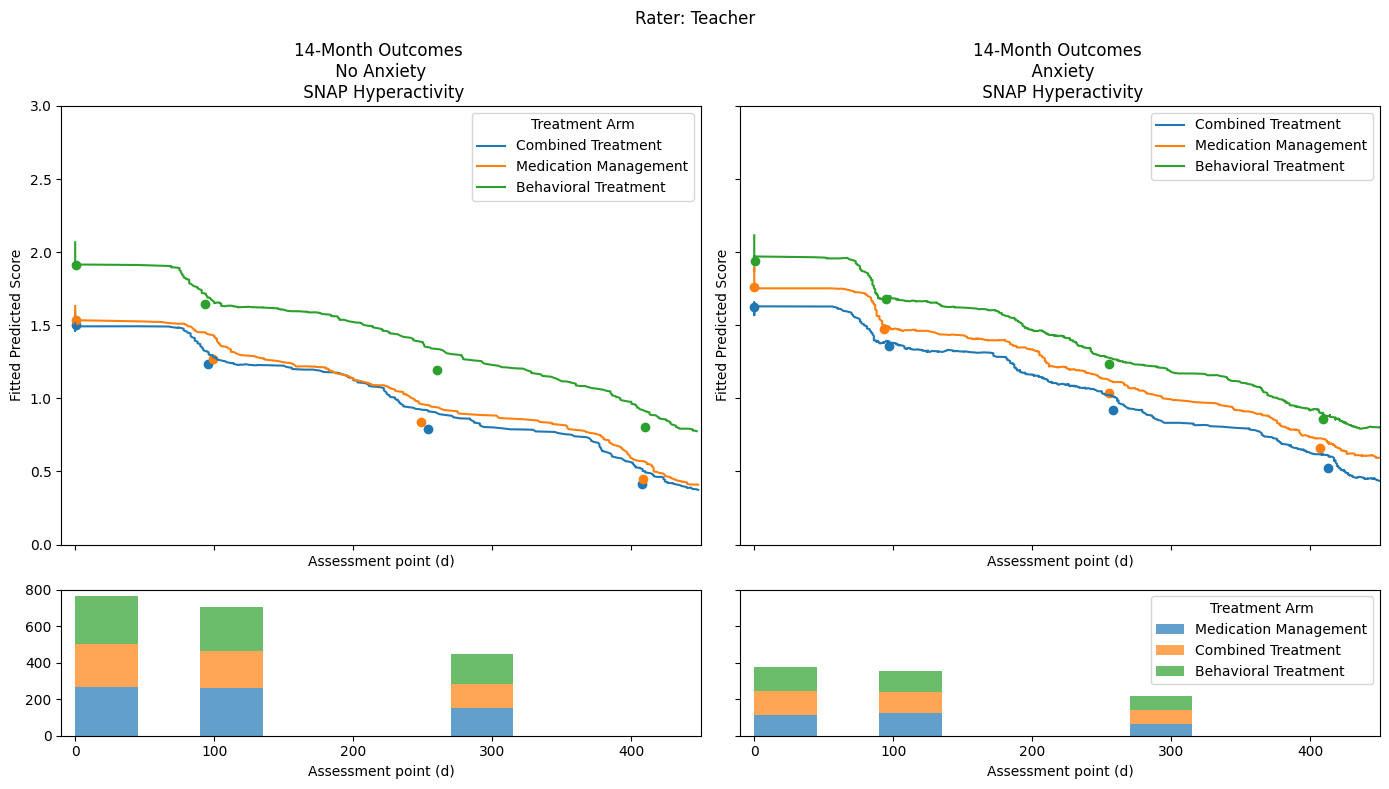

In [293]:
plot_RR_results(data, var_mod, var_out, med_values, type_plot=type_plot, window= window, timepoints_range=timepoints_range, trt_dict=trt_dict, rater=rater, xlim=xlim, ylim=ylim)

In [269]:
data_dict['snap'].keys()

Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'snainatx', 'snahypax', 'snaoddx', 'days_baseline', 'site',
       'version_form', 'trtname', 'cdorodd', 'anx', 'hi_24', 'demo61',
       'd2dresp', 'predicted_cdorodd_snainatx_T',
       'predicted_cdorodd_snahypax_T', 'predicted_cdorodd_snaoddx_T',
       'predicted_anx_snainatx_T', 'predicted_anx_snahypax_T',
       'predicted_anx_snaoddx_T', 'predicted_demo61_snainatx_T',
       'predicted_demo61_snahypax_T', 'predicted_demo61_snaoddx_T',
       'predicted_hi_24_snainatx_T', 'predicted_hi_24_snahypax_T',
       'predicted_hi_24_snaoddx_T', 'predicted_d2dresp_snainatx_T',
       'predicted_d2dresp_snahypax_T', 'predicted_d2dresp_snaoddx_T',
       'predicted_sex_snainatx_T', 'predicted_sex_snahypax_T',
       'predicted_sex_snaoddx_T', 'predicted_cdorodd_snainatx_P',
       'predicted_cdorodd_snahypax_P', 'predicted_cdorodd_snaoddx_P',
       'predicted_anx_snainatx_P', 'predicted_anx_snahypax_P'

In [ ]:
test_data = data_dict['snap']
test_data.keys()
var2plot = 'predicted_anx_snahypax'
test_data[var2plot].shape
print(test_data['days_baseline'].dropna().shape, test_data[var2plot].dropna().shape)

## 4 POINTS AV

In [60]:
def plot_4_point_av_fit(data, var_mod, var_out, med_values, window,  trt_dict , rater = None, show = True, save_path= None):
    print(show, save_path)
    ylim = [0,3]
    xlim = [-10, 450]
    pred_col_name= 'predicted_' + var_mod + '_' + var_out
    var_result = pred_col_name
    trtnames = data['trtname'].unique()
    pred_col_name= 'predicted_' + var_mod + '_' + var_out

    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
                '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]

    values = med_values[var_mod]
    print(values)
    # Create subplots: 2 rows (1st row for polynomial fit, 2nd row for bar plot)
    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
    else:
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >=-window) & (data['days_baseline'] <= 450)]
        
        
    print(yes_mod.shape, no_mod.shape)
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, sharey='row')
    if rater is not None: 
        plt.suptitle('Rater: ' + rater)

    # Loop over each treatment name and plot both the 'yes' and 'no' condition in separate subplots
    for trt in trtnames:


        df_yes = yes_mod[yes_mod['trtname'] == trt].dropna(subset=[pred_col_name])
        df_no = no_mod[no_mod['trtname'] == trt].dropna(subset=[pred_col_name])
        
        smoothed_yes = get_rolling_av(df_yes, pred_col_name, window)
        pnt_av = get_point_av(smoothed_yes, timepoints_range)
        
        smoothed_no = get_rolling_av(df_no, pred_col_name, window)
        pnt_av = get_point_av(smoothed_no, timepoints_range)
        x_fit_min = min(point_av_yes[:, 0].min(), point_av_yes[:, 0].min())
        x_fit_max = max(point_av_yes[:, 0].max(), point_av_no[:, 0].max())

        # Generate 100 evenly spaced points between the min and max values
        x_fit = np.linspace(x_fit_min, x_fit_max, 100)

        # Remove NaN and Infinite values
        point_av_no = point_av_no[~np.isnan(point_av_no).any(axis=1)]
        point_av_no = point_av_no[~np.isinf(point_av_no).any(axis=1)]
        point_av_yes = point_av_yes[~np.isnan(point_av_yes).any(axis=1)]
        point_av_yes = point_av_yes[~np.isinf(point_av_yes).any(axis=1)]

        # Ensure enough points for polynomial fitting
        if len(point_av_no) > 2 and len(point_av_yes) > 2:
            try:
                # Polynomial fit for 'yes'
                poly_fit_yes = np.polyfit(point_av_yes[:, 0], point_av_yes[:, 1], 2)
                poly_function_yes = np.poly1d(poly_fit_yes)
                y_fit_yes = poly_function_yes(x_fit)
                axes[0, 0].scatter(point_av_yes[:, 0], point_av_yes[:, 1], label=trt_dict[trt])
                axes[0, 0].plot(x_fit, y_fit_yes, linestyle='--', label=trt_dict[trt])
            except np.linalg.LinAlgError:
                print("Polynomial fit for 'yes' failed due to singular matrix")

            try:
                # Polynomial fit for 'no'
                poly_fit_no = np.polyfit(point_av_no[:, 0], point_av_no[:, 1], 2)
                poly_function_no = np.poly1d(poly_fit_no)
                y_fit_no = poly_function_no(x_fit)
                axes[0, 1].scatter(point_av_no[:, 0], point_av_no[:, 1], label=trt_dict[trt])
                axes[0, 1].plot(x_fit, y_fit_no, linestyle='--', label=trt_dict[trt])
            except np.linalg.LinAlgError:
                print("Polynomial fit for 'no' failed due to singular matrix")
        else:
            print("Not enough points for polynomial fit in treatment group:", trt)

            # Plot bar plot for the number of data points in the 'yes' condition (bottom left)
            #axes[1, 0].bar(time, n_yes, width=40, align='center', label=trt_dict[trt])
            
            # Plot bar plot for the number of data points in the 'no' condition (bottom right)
            #axes[1, 1].bar(time, n_no, width=40, align='center', label=trt_dict[trt])


    axes[0, 0].set_xlabel('Assessment point (d)')
    axes[0, 0].set_ylabel('Fitted Predicted Score')
    axes[0, 0].legend(title='Treatment Arm')
    axes[0, 0].set_xlim(xlim)  # Set x-axis limits
    axes[0, 0].set_ylim(ylim)  # Set y-axis limits
    axes[0, 0].set_title(title[0])
    # Add labels and titles to the subplots
    #axes[1, 0].set_title(title[1])
    #axes[0, 1].set_xlim(xlim)  # Set x-axis from 0 to 450
    #axes[0, 1].set_ylim(ylim)  # Ensure y-axis is from 0 to 3

    axes[0, 1].set_title(title[1])
    axes[0, 1].set_xlabel('Assessment point (d)')
    axes[0, 1].set_ylabel('Fitted Predicted Score')
    axes[0, 1].legend()




    # Set xlim and ylim
    axes[0, 0].set_xlim(x_lim)
    axes[0, 1].set_xlim(x_lim)
    axes[1, 0].set_xlim(x_lim)
    axes[1, 1].set_xlim(x_lim)

    axes[0, 0].set_ylim(y_lim)
    axes[0, 1].set_ylim(y_lim)


    bins = timepoints  # Adjust the number of bins as needed

    #Bar plot for "No Anxiety"
    trt_groups_no = no_mod['trtname'].unique()
    counts_by_trt_no = {trt: np.histogram(no_mod[no_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_no}

    # Initialize bottom for stacked bars
    bottom_no = np.zeros(len(bins)-1)

    # Plot the stacked bars for "No  mediator"
    for trt in trt_groups_no:
        counts = counts_by_trt_no[trt]
        axes[1, 0].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_no, label=trt_dict[trt], alpha=0.7)
        bottom_no += counts  # Update bottom for the next treatment group

    # Bar plot for "Anxiety"
    trt_groups_yes = yes_mod['trtname'].unique()
    counts_by_trt_yes = {trt: np.histogram(yes_mod[yes_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_yes}

    # Initialize bottom for stacked bars
    bottom_yes = np.zeros(len(bins)-1)


    # Plot the stacked bars for "Anxiety"
    for trt in trt_groups_yes:
        counts = counts_by_trt_yes[trt]
        axes[1, 1].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_yes, label=trt_dict[trt], alpha=0.7)
        bottom_yes += counts  # Update bottom for the next treatment group

    axes[1, 1].set_xlabel('Assessment point (d)')
    axes[1, 0].set_xlabel('Assessment point (d)')
    axes[1, 1].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 1].set_ylim([0,800])  # Match x-axis to the upper plot
    axes[1, 1].legend(title='Treatment Arm')

    if save_path is not None:
        folder_path = Path(save_path) / 'four_pt_fit'
        folder_path.mkdir(exist_ok=True)
        fig_name = var_result + '_' + str(rater[0]) + '.jpg' if rater is not None else var_result + '.jpg'
        print(folder_path)
        plt.savefig(folder_path / fig_name, dpi=300)

    if show:
        plt.tight_layout()
        plt.show()

## MOVING AV

In [112]:
def plot_moving_av(data, var_mod, var_out, med_values, window,  trt_dict , rater =None, show = True, save_path= None):
    ylim = [0,3]
    xlim = [-10, 450]
    pred_col_name= 'predicted_' + var_mod + '_' + var_out
    values = med_values[var_mod]    
    
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
                '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]

    # get data for yes and no mediator condition 
    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
    else:
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >=-window) & (data['days_baseline'] <= 450)]

    # Create subplots (2 rows, 2 columns) with shared x-axis
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    if rater is not None: 
        plt.suptitle('Rater: ' + rater)
        
    # Plot for "No Anxiety" subgroup
    for trt in no_mod['trtname'].unique():
        print(trt)
        # Subset data by treatment group and sort by 'days_baseline'
        subset = no_mod[no_mod['trtname'] == trt]
        n = subset.shape[0]

        smoothed_df = get_rolling_av(subset, pred_col_name, window)
        point_av = get_point_av(smoothed_df, timepoints_range)

        axes[ 0, 0 ].scatter(point_av[:,0], point_av[:,1])
        axes[0, 0].plot(smoothed_df['days_baseline'], smoothed_df['smoothed_value'], label=trt_dict[trt] + ' (n = {})'.format(n))

    # Set labels, title, and limits
    axes[0, 0].set_xlabel('Days Baseline')
    axes[0, 0].set_ylabel('Smoothed Predicted Score')
    axes[0, 0].legend(title='Treatment Arm')
    axes[0, 0].set_xlim(xlim)  # Set x-axis limits
    axes[0, 0].set_ylim(ylim)  # Set y-axis limits
    axes[0, 0].set_title(title[0])


    for trt in yes_mod['trtname'].unique():
        print(trt)
        # Subset data by treatment group and sort by 'days_baseline'
        subset = yes_mod[yes_mod['trtname'] == trt]
        n = subset.shape[0]
        
        smoothed_df = get_rolling_av(subset, pred_col_name, window)
        point_av = get_point_av(smoothed_df, timepoints_range)
        
        axes[ 0, 1].scatter(point_av[:,0], point_av[:,1])
            # Plot the line using the sorted 'days_baseline' and corresponding rolling mean
        axes[0, 1].plot(smoothed_df['days_baseline'], smoothed_df['smoothed_value'], label=trt_dict[trt] + ' (n = {})'.format(n))

    axes[0, 1].set_title(title[1])
    axes[0, 1].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[0, 1].set_ylim(ylim)  # Ensure y-axis is from 0 to 3

    ### Second row: Stacked bar plots for the number of data points colored by treatment group ###

    # Define bins for the time points (based on 'days_baseline')
    bins = np.linspace(0, 450, num=10)  # Adjust the number of bins as needed

    #Bar plot for "No Anxiety"
    trt_groups_no = no_mod['trtname'].unique()
    counts_by_trt_no = {trt: np.histogram(no_mod[no_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_no}

    # Initialize bottom for stacked bars
    bottom_no = np.zeros(len(bins)-1)

    # Plot the stacked bars for "No  mediator"
    for trt in trt_groups_no:
        counts = counts_by_trt_no[trt]
        axes[1, 0].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_no, label=trt_dict[trt], alpha=0.7)
        bottom_no += counts  # Update bottom for the next treatment group

    axes[1, 0].set_ylabel('Number of Data Points')
    axes[1, 0].set_xlabel('Assessment point (d)')
    axes[1, 0].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 0].set_ylim([0,800])
    axes[1, 0].legend(title='Treatment Arm')

    # Bar plot for "Anxiety"
    trt_groups_yes = yes_mod['trtname'].unique()
    counts_by_trt_yes = {trt: np.histogram(yes_mod[yes_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_yes}

    # Initialize bottom for stacked bars
    bottom_yes = np.zeros(len(bins)-1)
    # Plot the stacked bars for "Anxiety"
    for trt in trt_groups_yes:
        counts = counts_by_trt_yes[trt]
        axes[1, 1].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_yes, label=trt_dict[trt], alpha=0.7)
        bottom_yes += counts  # Update bottom for the next treatment group

    axes[1, 1].set_xlabel('Assessment point (d)')
    axes[1, 1].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 1].set_ylim([0,800])  # Match x-axis to the upper plot
    axes[1, 1].legend(title='Treatment Arm')

    ## Save or Show the plot ###
    if save_path is not None:
        folder_path = Path(save_path) / 'mov_av'
        folder_path.mkdir(parents=True, exist_ok=True)
        fig_name = pred_col_name + '_' + str(rater[0]) + '.jpg' if rater is not None else var_result + '.jpg'
        plt.savefig(folder_path / fig_name, dpi=300)

    if show:
        plt.tight_layout()
        plt.show()

In [ ]:
plot = True
save_path = Path('/Users/alina/Desktop/MIT/code/data/output/figures/mediator_regression_14months')
to_plot = qsts
extract_results = True
window = 50
plot_type= 'four_pt_fit' # smooth #four_pnt


for qst in to_plot:
    if qst == 'snap' or qst == 'ssrs':
        print('SNAP, SSRS')
        for rater in raters:
            for key in results[qst][rater].keys():

                if key.startswith('hi'):
                    var_mod = split_on_occurrence(key, '_', 2)[0]
                    var_out= split_on_occurrence(key, '_', 2)[1]
                else: 
                    var_mod = key.split('_')[0]
                    var_out =  key.split('_')[1]

                title = [rater + '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 

                data = data_dict[qst]
                result = results[qst][rater]

                
                var_result = var_mod + '_' + var_out

                title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
                values = med_values[var_mod]
                
                if extract_results:
                    result = result[var_result]
                    data = data_dict[qst]
                    data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) #put teh result in original dataframe for later access 
                
                
                if plot_type == 'mov_av' : 
                    plot_moving_av(data, var_mod, var_out, med_values, window, trt_dict, rater = rater, show = plot, save_path= None)
                elif plot_type == 'smooth' : 
                    plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, save_path=save_path)
                elif plot_type == 'four_pt_fit':
                    plot_4_point_av_fit(data, var_mod, var_out, med_values, window, trt_dict, rater = rater, show = plot, save_path= None)
                    


    else: 
        print('MASC; PC')
        for key in results[qst].keys():
            print(qst)
            if key.startswith('hi'):
                var_mod = split_on_occurrence(key, '_', 2)[0]
                var_out= split_on_occurrence(key, '_', 2)[1]
            elif 'masc' in key:
                var_mod = split_on_occurrence(key, '_', 1)[0]
                var_out= split_on_occurrence(key, '_', 1)[1]
            else:
                var_mod = key.split('_')[0]
                var_out =  key.split('_')[1]
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 
            data = data_dict[qst]
            result = results[qst]

            
            var_result = var_mod + '_' + var_out
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
            values = med_values[var_mod]
            if extract_results:
                result = result[var_result]
                data = data_dict[qst]
                data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) #put teh result in original dataframe for later access 

            if plot_type == 'mov_av' : 
                print('MOV AV')
                print(save_path)
                plot_moving_av(data= data, var_mod=var_mod, var_out=var_out,med_values= med_values,window= window,trt_dict= trt_dict, rater = rater, show = plot, save_path= save_path)  
            elif plot_type == "smooth":
                plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, show= False, save_path=save_path)
            elif plot_type == 'four_pt_fit':
                plot_4_point_av_fit(data= data, var_mod=var_mod, var_out=var_out,med_values= med_values,window= window,trt_dict= trt_dict, rater = rater, show = plot, save_path= save_path)  


In [92]:
results

{'snap': {'Teacher': {'cdorodd_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87fc66fbe0>,
   'cdorodd_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87cc800ca0>,
   'cdorodd_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87ca98c2b0>,
   'anx_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87f95620b0>,
   'anx_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87f9563c70>,
   'anx_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87f9563ac0>,
   'demo61_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87cab83610>,
   'demo61_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87cab83490>,
   'demo61_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87cabdf220>,
   'hi_24_snainatx': <stats

In [110]:
def extract_prediction(results, data_dict):
    # extract predicted datapoints for all questionnaires
    for qst in to_plot:
        if qst == 'snap' or qst == 'ssrs':
            print(qst.upper())
            for rater in raters:
                for var_result in results[qst][rater].keys():    
                    result = results[qst][rater][var_result]
                    #print(result)
                    data = data_dict[qst]
                    data_dict[qst]['predicted_' +  str(var_result) +'_' + str(rater[0])] = result.predict(data) #
                    
        elif qst == 'masc' or qst == 'pc':    
            print(qst.upper())       
            for var_result in results[qst].keys():
                data = data_dict[qst]
                result = results[qst][var_result]
                data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) 
                
                
def get_point_av(df, pred_col_name, timepoints_range):
    df.sort_values('days_baseline')
    subset = df[['days_baseline', pred_col_name]]
    point_av = np.array([ subset[subset['days_baseline'].isin(range(range_t[0], range_t[1]))].mean(axis = 0) for range_t in timepoints_range])
    return point_av 

In [111]:
extract_prediction(results, data_dict)

SNAP
SSRS
MASC
PC


In [141]:
data = data_dict['snap']
col_name = 'predicted_demo61_snaoddx_P'
data[col_name]


(3033,)

In [143]:

test_ptn_av = get_point_av(data, col_name, timepoints_range)

In [154]:

line = extract_line_plot(data, pred_col_name=col_name, type_plot='four_pnt_fit',pnt_av= test_ptn_av, window=50)
print(line)



type four point polynomial fit
[1.26890409 1.26340478 1.25792662 1.25246959 1.24703369 1.24161893
 1.23622531 1.23085282 1.22550147 1.22017126 1.21486218 1.20957423
 1.20430743 1.19906175 1.19383722 1.18863382 1.18345156 1.17829043
 1.17315044 1.16803158 1.16293386 1.15785727 1.15280183 1.14776751
 1.14275434 1.1377623  1.13279139 1.12784162 1.12291299 1.11800549
 1.11311913 1.1082539  1.10340981 1.09858686 1.09378504 1.08900436
 1.08424481 1.0795064  1.07478913 1.07009299 1.06541799 1.06076412
 1.05613139 1.0515198  1.04692934 1.04236002 1.03781183 1.03328478
 1.02877886 1.02429408 1.01983044 1.01538793 1.01096656 1.00656632
 1.00218722 0.99782926 0.99349243 0.98917674 0.98488218 0.98060876
 0.97635648 0.97212533 0.96791532 0.96372644 0.9595587  0.95541209
 0.95128662 0.94718229 0.94309909 0.93903703 0.9349961  0.93097631
 0.92697766 0.92300014 0.91904376 0.91510851 0.9111944  0.90730143
 0.90342959 0.89957889 0.89574932 0.89194089 0.8881536  0.88438744
 0.88064241 0.87691853 0.873215

In [126]:
col_name

'predicted_demo61_snaoddx_P'

In [ ]:
def plot_RR_mediators(data, var_mod, var_out, plot_type, med_values, timepoints_range, window,  trt_dict ,xlim, ylim,  rater = None, show = True, save_path= None):
    
    pred_col_name= 'predicted_' + var_mod + '_' + var_out

    trtnames = data['trtname'].unique()

    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
                '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]

    values = med_values[var_mod]
    
    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
    else:
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >=-window) & (data['days_baseline'] <= 450)]
        
        
    print(yes_mod.shape, no_mod.shape)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, sharey='row')
    if rater is not None: 
        plt.suptitle('Rater: ' + rater)

    # Loop over each treatment name and plot both the 'yes' and 'no' condition in separate subplots
    for trt in trtnames:
        yes_mod = yes_mod.sort_values('days_baseline')
        no_mod = no_mod.sort_values('days_baseline')
        four_point_av_yes = get_point_av(yes_mod, pred_col_name, timepoints_range)

In [119]:
timepoints_range

[[-50, 50], [40, 140], [220, 320], [370, 470]]

In [122]:
data_dict['snap'].keys()

Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'snainatx', 'snahypax', 'snaoddx', 'days_baseline', 'site',
       'version_form', 'trtname', 'cdorodd', 'anx', 'hi_24', 'demo61',
       'd2dresp', 'predicted_cdorodd_snainatx_T',
       'predicted_cdorodd_snahypax_T', 'predicted_cdorodd_snaoddx_T',
       'predicted_anx_snainatx_T', 'predicted_anx_snahypax_T',
       'predicted_anx_snaoddx_T', 'predicted_demo61_snainatx_T',
       'predicted_demo61_snahypax_T', 'predicted_demo61_snaoddx_T',
       'predicted_hi_24_snainatx_T', 'predicted_hi_24_snahypax_T',
       'predicted_hi_24_snaoddx_T', 'predicted_d2dresp_snainatx_T',
       'predicted_d2dresp_snahypax_T', 'predicted_d2dresp_snaoddx_T',
       'predicted_sex_snainatx_T', 'predicted_sex_snahypax_T',
       'predicted_sex_snaoddx_T', 'predicted_cdorodd_snainatx_P',
       'predicted_cdorodd_snahypax_P', 'predicted_cdorodd_snaoddx_P',
       'predicted_anx_snainatx_P', 'predicted_anx_snahypax_P'

In [123]:
test = data_dict['snap']
col_name = 'predicted_demo61_snaoddx_P'



In [124]:
get_point_av(test, col_name, timepoints_range)

array([[1.96774194e-01, 1.26622979e+00],
       [9.55238095e+01, 1.15402220e+00],
       [2.55460465e+02, 9.67050676e-01],
       [4.13035556e+02, 8.28304041e-01]])

In [ ]:
plot = False
save_path =  None #Path('/Users/alina/Desktop/MIT/code/data/output/figures/mediator_regression_14months')
to_plot = qsts
extract_prediction = False
window = 30
plot_type= 'mov_av' # smooth #four_pnt


for qst in to_plot:
    if qst == 'snap' or qst == 'ssrs':
        print('SNAP, SSRS')
        for rater in raters:
            for key in results[qst][rater].keys():

                if key.startswith('hi'):
                    var_mod = split_on_occurrence(key, '_', 2)[0]
                    var_out= split_on_occurrence(key, '_', 2)[1]
                else: 
                    var_mod = key.split('_')[0]
                    var_out =  key.split('_')[1]

                title = [rater + '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 

                data = data_dict[qst]
                result = results[qst][rater]

                
                var_result = var_mod + '_' + var_out

                title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
                values = med_values[var_mod]
                
                if extract_prediction:
                    extract_prediction(results, data_dict)
                
                if plot_type == 'mov_av' : 
                    plot_moving_av(data, var_mod, var_out, med_values, window, trt_dict, rater = rater, show = plot, save_path= None)
                elif plot_type == 'smooth' : 
                    plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, save_path=save_path)
                elif plot_type == 'four_pt_fit':
                    plot_4_point_av_fit(data, var_mod, var_out, med_values, window, trt_dict, rater = rater, show = plot, save_path= None)
                    


    else: 
        print('MASC; PC')
        for key in results[qst].keys():
            print(qst)
            if key.startswith('hi'):
                var_mod = split_on_occurrence(key, '_', 2)[0]
                var_out= split_on_occurrence(key, '_', 2)[1]
            elif 'masc' in key:
                var_mod = split_on_occurrence(key, '_', 1)[0]
                var_out= split_on_occurrence(key, '_', 1)[1]
            else:
                var_mod = key.split('_')[0]
                var_out =  key.split('_')[1]
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 
            data = data_dict[qst]
            result = results[qst]

            
            var_result = var_mod + '_' + var_out
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
            values = med_values[var_mod]
            if extract_results:
                result = result[var_result]
                data = data_dict[qst]
                data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) #put teh result in original dataframe for later access 

            if plot_type == 'mov_av' : 
                print('MOV AV')
                print(save_path)
                plot_moving_av(data= data, var_mod=var_mod, var_out=var_out,med_values= med_values,window= window,trt_dict= trt_dict, rater = rater, show = plot, save_path= save_path)  
            elif plot_type == "smooth":
                plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, show= False, save_path=save_path)
            elif plot_type == 'four_pt_fit':
                plot_4_point_av_fit(data= data, var_mod=var_mod, var_out=var_out,med_values= med_values,window= window,trt_dict= trt_dict, rater = rater, show = plot, save_path= save_path)  


In [ ]:
plot = False
save_path = Path('/Users/alina/Desktop/MIT/code/data/output/figures/mediator_regression_14months')
to_plot = qsts
extract_results = True
window = 50
plot_type= 'smoothß' # smooth #four_pnt


for qst in to_plot:
    if qst == 'snap' or qst == 'ssrs':
        print('SNAP, SSRS')
        for rater in raters:
            for key in results[qst][rater].keys():

                if key.startswith('hi'):
                    var_mod = split_on_occurrence(key, '_', 2)[0]
                    var_out= split_on_occurrence(key, '_', 2)[1]
                else: 
                    var_mod = key.split('_')[0]
                    var_out =  key.split('_')[1]

                title = [rater + '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 

                data = data_dict[qst]
                result = results[qst][rater]

                
                var_result = var_mod + '_' + var_out

                title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
                values = med_values[var_mod]
                
                if extract_results:
                    result = result[var_result]
                    data = data_dict[qst]
                    data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) #put teh result in original dataframe for later access 
                
                
                if plot_type == 'mov_av' : 
                    plot_moving_av(data, var_mod, var_out, med_values, window, trt_dict, rater = rater, show = plot, save_path= None)
                elif plot_type == 'smooth' : 
                    plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, save_path=save_path)
                elif plot_type == 'four_pt_fit':
                    plot_4_point_av_fit(data, var_mod, var_out, med_values, window, trt_dict, rater = rater, show = plot, save_path= None)
                    


    else: 
        print('MASC; PC')
        for key in results[qst].keys():
            print(qst)
            if key.startswith('hi'):
                var_mod = split_on_occurrence(key, '_', 2)[0]
                var_out= split_on_occurrence(key, '_', 2)[1]
            elif 'masc' in key:
                var_mod = split_on_occurrence(key, '_', 1)[0]
                var_out= split_on_occurrence(key, '_', 1)[1]
            else:
                var_mod = key.split('_')[0]
                var_out =  key.split('_')[1]
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 
            data = data_dict[qst]
            result = results[qst]

            
            var_result = var_mod + '_' + var_out
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
            values = med_values[var_mod]
            if extract_results:
                result = result[var_result]
                data = data_dict[qst]
                data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) #put teh result in original dataframe for later access 

            if plot_type == 'mov_av' : 
                print('MOV AV')
                print(save_path)
                plot_moving_av(data= data, var_mod=var_mod, var_out=var_out,med_values= med_values,window= window,trt_dict= trt_dict, rater = rater, show = plot, save_path= save_path)  
            elif plot_type == "smooth":
                plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, show= False, save_path=save_path)
            elif plot_type == 'four_pt_fit':
                plot_4_point_av_fit(data= data, var_mod=var_mod, var_out=var_out,med_values= med_values,window= window,trt_dict= trt_dict, rater = rater, show = plot, save_path= save_path)  
